In [738]:
import numpy as np
from matplotlib.dates import DayLocator, MonthLocator, DateFormatter
from matplotlib.ticker import AutoLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
from scipy.signal import savgol_filter
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

# Plots

In [638]:
def plot_acf_pacf(df_orbital, satellite_name, variable, lags=30, figsize=(16, 4), 
                  save_path=None, adjust_y_axis=True, dpi=300):
    """
    Plot ACF and PACF for a selected satellite and variable.
    
    Parameters:
    -----------
    df_orbital : pandas DataFrame
        The dataframe containing orbital data for multiple satellites
    satellite_name : str
        The name of the satellite to filter for
    variable : str
        The variable/column name to analyze
    lags : int, default=30
        Number of lags to include in the plots
    figsize : tuple, default=(16, 4)
        Size of the figure (width, height)
    save_path : str or None, default=None
        Path to save the figure. If None, the figure is not saved
    adjust_y_axis : bool, default=True
        Whether to adjust the y-axis limits based on the data
    dpi : int, default=300
        Resolution for the saved figure
        
    Returns:
    --------
    fig : matplotlib Figure
        The figure object containing the plots
    """
    # Filter the dataframe for the specified satellite
    df_filtered =df_orbital[df_orbital['satellite_name'] == satellite_name].copy()
    
    # Check if the filtered dataframe is empty
    if df_filtered.empty:
        raise ValueError(f"No data found for satellite '{satellite_name}'")
    
    # Check if the variable exists in the dataframe
    if variable not in df_filtered.columns:
        raise ValueError(f"Variable '{variable}' not found in the dataframe")
    
    # Get the data series for the specified variable
    data_series = df_filtered[variable]
    
    # Create the figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    
    # Calculate ACF and PACF values
    acf_values = sm.tsa.acf(data_series, nlags=lags)
    pacf_values = sm.tsa.pacf(data_series, nlags=lags)
    
    # Plot ACF - use the statsmodels plot_acf function with the specified axis
    sm.graphics.tsa.plot_acf(data_series, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f"Autocorrelation Function (ACF)")
    axes[0].set_xlabel(f"Lag (days)")
    axes[0].set_ylabel("Correlation coefficient")
    
    # Plot PACF - use the statsmodels plot_pacf function with the specified axis
    sm.graphics.tsa.plot_pacf(data_series, lags=lags, ax=axes[1], alpha=0.05)
    axes[1].set_title(f"Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel(f"Lag (days)")
    axes[1].set_ylabel("Correlation coefficient")
    
    # Adjust y-axis limits if requested
    if adjust_y_axis:
        # Find min and max values, adding a small buffer
        min_val = min(min(acf_values), min(pacf_values)) - 0.05
        max_val = max(max(acf_values), max(pacf_values)) + 0.05
        
        # Ensure the range is at least 0.2 to avoid too narrow plots
        if max_val - min_val < 0.2:
            mean = (max_val + min_val) / 2
            min_val = mean - 0.1
            max_val = mean + 0.1
        
        # Set the limits but don't exceed the standard -1 to 1 range
        y_min = max(-1, min_val)
        y_max = min(1, max_val)
        
        axes[0].set_ylim(y_min, y_max)
        axes[1].set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    # Save the figure if a path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

In [779]:
def plot_residuals_vs_maneuvers(
    residuals,
    df_maneuver,
    xlim=None,
    save_path=None
):
    """
    Plots residuals with vertical lines for maneuvers.

    Parameters:
    - residuals: Pandas Series of residuals with datetime index
    - df_maneuver: DataFrame with a 'start_date' column
    - xlim: Optional (start_date, end_date) tuple for zooming
    - save_path: Optional path to save the figure
    """
    import matplotlib.pyplot as plt
    import pandas as pd

    plt.figure(figsize=(14, 5))
    
    # Plot residuals
    plt.plot(residuals.index, residuals, color='crimson', label='Residuals')
    
    # Zero line
    plt.axhline(0, linestyle='--', color='black', linewidth=0.5)
    
    # Plot vertical lines for maneuvers
    for i, row in df_maneuver.iterrows():
        plt.axvline(
            x=row['start_date'],
            color='navy',
            linestyle='--',
            alpha=0.7
        )
    
    # Optional zoom
    if xlim is not None:
        plt.xlim(pd.to_datetime(xlim[0]), pd.to_datetime(xlim[1]))

        # Adjust y-range to visible data
        visible_resid = residuals[(residuals.index >= xlim[0]) & (residuals.index <= xlim[1])]
        y_min, y_max = visible_resid.min(), visible_resid.max()
        y_pad = (y_max - y_min) * 0.1 if y_max > y_min else 0.001
        plt.ylim(y_min - y_pad, y_max + y_pad)

    # Titles and labels
    plt.ylabel('Residual (rescaled)')

    # Create custom legend
    from matplotlib.lines import Line2D
    custom_lines = [
        Line2D([0], [0], color='crimson', lw=2, label='Residuals'),
        Line2D([0], [0], color='navy', lw=2, linestyle='--', label='-- Maneuver Timestamp')
    ]
    plt.legend(handles=custom_lines, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

    plt.grid(False)
    plt.tight_layout()

    # Save plot if save_path is provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Raw Orbital Data (TLE records)

In [785]:
orbital_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\all_satellite_orbitals.csv"
maneuver_file = r"C:\Users\Suare\satellite_anomaly_project\data\cleaned\cleaned_maneuvers.csv"
df_orbital = pd.read_csv(orbital_file)
df_maneuver = pd.read_csv(maneuver_file)

In [787]:
#Filter the dataset with the satellites selected for the report
df_orbital_filtered = df_orbital[
    df_orbital['satellite_name'].isin(["Fengyun_2E", "Fengyun_2F","Fengyun_4A", "Jason_3", "Sentinel_3A"])]
df_orbital_filtered.head()

,epoch,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension,epoch_date,satellite_name
5495,2011-03-13 19:49:07.927679,0.000166,3.132580,0.015554,-4.721355,0.004375,5.297914,2011-03-13,Fengyun_2E
5496,2011-03-14 06:58:21.993311,0.000165,3.137278,0.015532,-1.798237,0.004375,5.297874,2011-03-14,Fengyun_2E
5497,2011-03-15 16:04:54.898175,0.000172,3.093497,0.015502,-5.633806,0.004375,5.301572,2011-03-15,Fengyun_2E
5498,2011-03-16 22:22:53.164991,0.000168,3.110608,0.015465,-3.982810,0.004374,5.303478,2011-03-16,Fengyun_2E
5499,2011-03-17 17:43:47.943840,0.000170,3.240418,0.015436,-5.319086,0.004374,5.305537,2011-03-17,Fengyun_2E


In [876]:
#Choose the satellite and variable to analyse.
satellite = "Fengyun_2F"
variable = "Brouwer mean motion"

In [878]:
#Filter Manuevers dataset
df_maneuver = df_maneuver[df_maneuver['OrbitalKeyName'] == satellite]

In [880]:
df_maneuver.head()

,OrbitalKeyName,satellite,start_year,start_doy,start_hour,start_minute,end_year,end_doy,end_hour,end_minute,maneuver_type,parameter_type,num_burns,start_datetime,end_datetime,duration_minutes,start_date


In [882]:
# Filter the dataset with one satellite
df = df_orbital[df_orbital['satellite_name'] == satellite][["epoch", "Brouwer mean motion"]]
df["epoch"] = pd.to_datetime(df["epoch"])
df = df.reset_index(drop=True)
# Set as index
df.set_index("epoch", inplace=True)

In [884]:
df.head()

,Brouwer mean motion
epoch,
2012-09-06 18:48:32.050655,0.004374
2012-09-07 19:39:45.383327,0.004374
2012-09-08 15:43:39.075167,0.004374
2012-09-09 12:53:36.595967,0.004374
2012-09-10 13:15:22.135391,0.004374


# Pre-Processing Base

In [887]:
#Centring and Scaling
df_mm = (df - df.mean())*1e7

In [889]:
# Resampling
# D stands for 'Daily' _ALL The mean function is when there are several records on the same day
df_resampled = df_mm.resample('D').mean()

In [891]:
#Interpolation
df_filled = df_resampled.interpolate(method='bfill')

# Pre-Processing Scnearios 

In [894]:
#Scenario 1: Base
stationarity_test = adfuller(df_filled[variable].dropna())
print("ADF Statistic:", stationarity_test[0])
print("p-value:", stationarity_test[1])

if stationarity_test[1] < 0.05:
    print("The series is stationary (reject H0).")
    df_base = df_filled.copy()
    
else:
    print("The series is NOT stationary (fail to reject H0).")
    df_base = df_filled.diff().dropna()

ADF Statistic: -18.677663271157456
p-value: 2.0428236319944425e-30
The series is stationary (reject H0).


In [896]:
#Scenario 2: Differentiating
df_diff = df_filled.diff().dropna()

In [898]:
#Scenario 3: Mean Absolute Deviation

# Extract column as a Series
series_mm = df_mm[variable]

# Calculate MAD-based sigma
median_value = series_mm.median()
absolute_deviations = (series_mm - median_value).abs()
sigma = absolute_deviations.median() * 1.4826  # Scale factor for normal distribution
print(f"MAD sigma estimate: {sigma:.4f}")

# Check if sigma is valid
if pd.isna(sigma) or sigma == 0:
    print("MAD calculation resulted in NaN or zero. Checking data...")
    print(f"Data median: {median_value}")
    print(f"Number of non-NaN values: {series_mm.count()}")
    print(f"Number of zeros: {(series_mm == 0).sum()}")
    # Fallback to standard deviation
    sigma = series_mm.std()
    print(f"Using standard deviation instead: {sigma:.4f}")

# Set threshold
thresh = 25 * sigma

# Create mask (True where NOT outlier)
mask = (series_mm - median_value).abs() <= thresh

# Keep only non-extreme values
series_outliers = series_mm[~mask]
series_cleaned = series_mm[mask].copy()
mask_resampled = series_cleaned.resample('D').mean()
mask_interpolation = mask_resampled.interpolate(method='bfill')

df_mad = mask_interpolation.to_frame(name=variable)
print(f"Detected {(~mask).sum()} extreme values out of {len(series_mm)} points.")

MAD sigma estimate: 4.2103
Detected 0 extreme values out of 2985 points.


In [900]:
series_outliers

Series([], Name: Brouwer mean motion, dtype: float64)

In [902]:
#Scenario 4: Log Transformation
#For scenario 4 we change the order, we transform first the series before the centering to avoid negative numbers
df_transform = np.log(df)
df_mm = (df_transform - df_transform.mean())*1e7
df_resampled = df_mm.resample('D').mean()
df_log = df_resampled.interpolate(method='bfill')

In [904]:
#Scenario 5: Smoothing (Savitzky–Golay)
# window_length must be odd and >= polyorder + 2
col = variable  
win  = 7   
poly = 1       

df_filled['bmm_savgol'] = savgol_filter(df_filled[col].values,
                                 window_length=win,
                                 polyorder=poly)
df_smooth = df_filled['bmm_savgol']

In [906]:
df_smooth.head()

epoch
2012-09-06   -6.627729
2012-09-07   -6.381027
2012-09-08   -6.134325
2012-09-09   -5.887623
2012-09-10   -5.691046
Freq: D, Name: bmm_savgol, dtype: float64

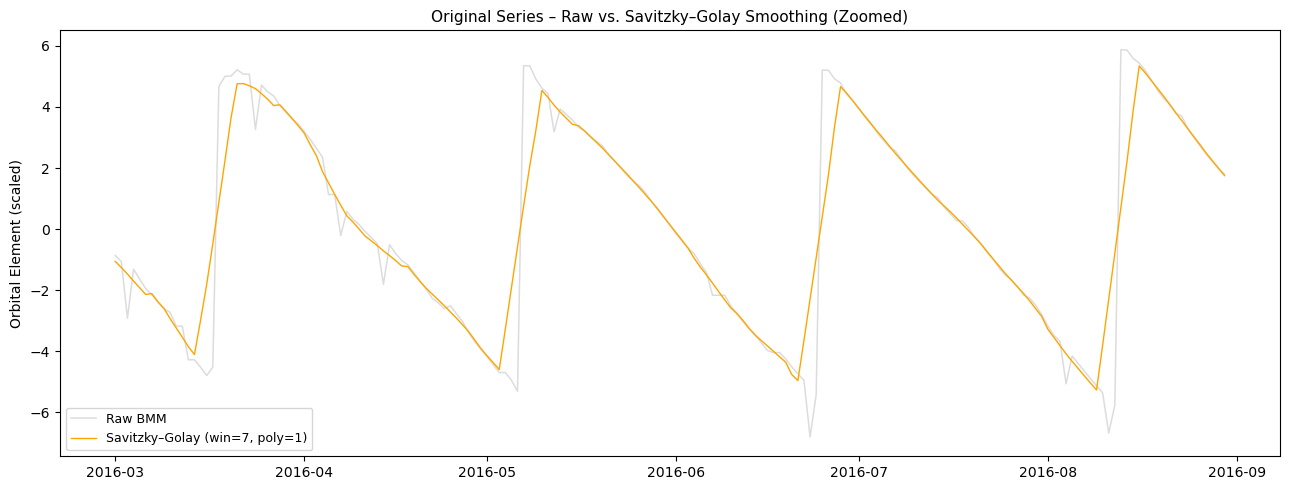

In [908]:
# --- Define Zoom Window ---
zoom_start = pd.to_datetime("2016-03-01")  # Adjust dates as needed
zoom_end = pd.to_datetime("2016-08-30")

# --- Apply zoom filter to orbital data ---
df_zoomed = df_filled[(df_filled.index >= zoom_start) & (df_filled.index <= zoom_end)].copy()

# --- Apply zoom filter to maneuver data ---
# Ensure maneuver dates are datetime type
df_maneuver['start_date'] = pd.to_datetime(df_maneuver['start_date'])

# Filter maneuvers within the zoom window
df_maneuver_zoomed = df_maneuver[(df_maneuver['start_date'] >= zoom_start) & (df_maneuver['start_date'] <= zoom_end)].copy()

# --- Plot ---
fig, ax = plt.subplots(figsize=(13, 5))

# Plot raw series
ax.plot(
    df_zoomed.index, df_zoomed[variable],
    label="Raw BMM",
    linewidth=1.1,
    alpha=0.4,
    color="darkgrey"
)

# Plot smoothed series
ax.plot(
    df_zoomed.index, df_zoomed["bmm_savgol"],
    label=f"Savitzky–Golay (win={win}, poly={poly})",
    linewidth=1,
    color="orange"
)

# Plot maneuver vertical lines
for _, row in df_maneuver_zoomed.iterrows():
    ax.axvline(
        x=row['start_date'],
        color="navy",
        linestyle="--",
        linewidth=1,
        alpha=0.7
    )

# Cosmetics
ax.set_title("Original Series – Raw vs. Savitzky–Golay Smoothing (Zoomed)", fontsize=11)
ax.set_ylabel("Orbital Element (scaled)", fontsize=10)
ax.legend(fontsize=9)

# --- Save figure ---
fig.savefig("figures/raw_vs_savgol_zoomed.png", dpi=300, bbox_inches='tight', transparent=False)

fig.tight_layout()
plt.show()

# ARIMA Model Fitting and Forecasting

In [911]:
# Define scenario number
scenario = 3  # <-- Change this number to select the scenario you want

# Map scenario number to corresponding DataFrame
if scenario == 1:
    ts = df_base.copy()
    d = 0 
elif scenario == 2:
    ts = df_base.copy() # the auto arima will be the one performing the differencing
    d = 1
elif scenario == 3:
    ts = df_mad.copy()
    d = 0
elif scenario == 4:
    ts = df_log.copy()
    d= 0
elif scenario == 5:
    ts = df_smooth.copy()
    d = 0
else:
    raise ValueError(f"Invalid scenario number: {scenario}. Must be between 1 and 5.")

# Print confirmation
print(f"Scenario {scenario} selected. Data shape: {ts.shape}")

Scenario 3 selected. Data shape: (3415, 1)


In [913]:
# ts =  time series (should already be prepared: resampled, interpolated, scaled, etc.)
# d =  differencing order (0 if no differencing needed, 1 if one differencing applied)

# Perform grid search
model = auto_arima(
    ts,
    start_p=0, max_p=5,     # AR order: 0 to 5
    start_q=0, max_q=5,     # MA order: 0 to 5
    d=d,                    # Differencing order fixed based on preprocessing
    seasonal=False,         # No seasonal component (ts is not truly seasonal)
    information_criterion='aic',   # Model selection based on AIC
    stepwise=False,         # Full grid search (not stepwise approximation)
    suppress_warnings=True, # Ignore warnings to keep output clean
    error_action='ignore',  # Ignore errors and continue searching
    trace=True              # Print AIC for each model
)

print(f"Best ARIMA model: {model.order} with AIC: {model.aic()}")

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18088.746, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=15499.772, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=14290.124, Time=0.51 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=13800.704, Time=0.48 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=13491.903, Time=0.57 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=13328.240, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=13052.587, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=13051.592, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=13050.025, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=13051.660, Time=0.59 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=13044.283, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=13051.357, Time=1.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=12874.318, Time=2.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=13051.635, Time=1.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=12868.717, Time=2.74

In [922]:
residuals = model.resid()

In [924]:
residuals.head()

epoch
2012-09-06   -5.969689
2012-09-07   -0.958298
2012-09-08   -0.960234
2012-09-09   -1.016837
2012-09-10   -1.103207
Freq: D, dtype: float64

# Residuals Analysis

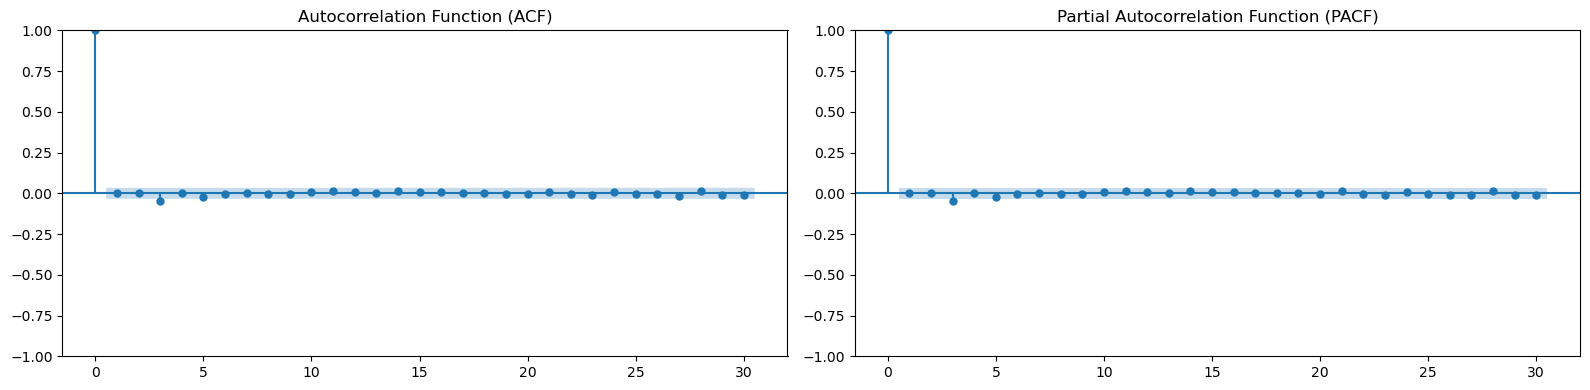

In [927]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # 1 row, 2 columns

# ACF plot
sm.graphics.tsa.plot_acf(residuals, lags=30, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
sm.graphics.tsa.plot_pacf(residuals, lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

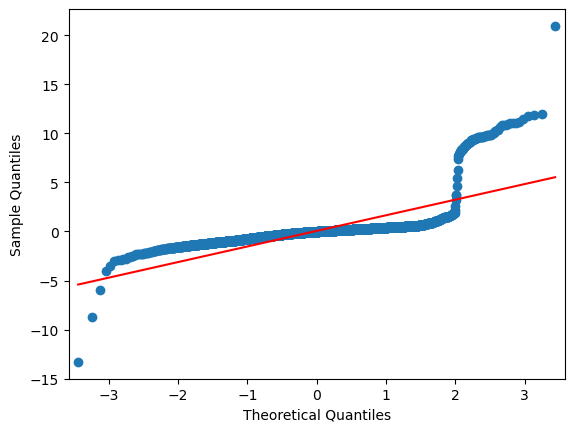

In [929]:
# plot a q-q plot of the residuals
sm.qqplot(residuals, line='s')
plt.show()

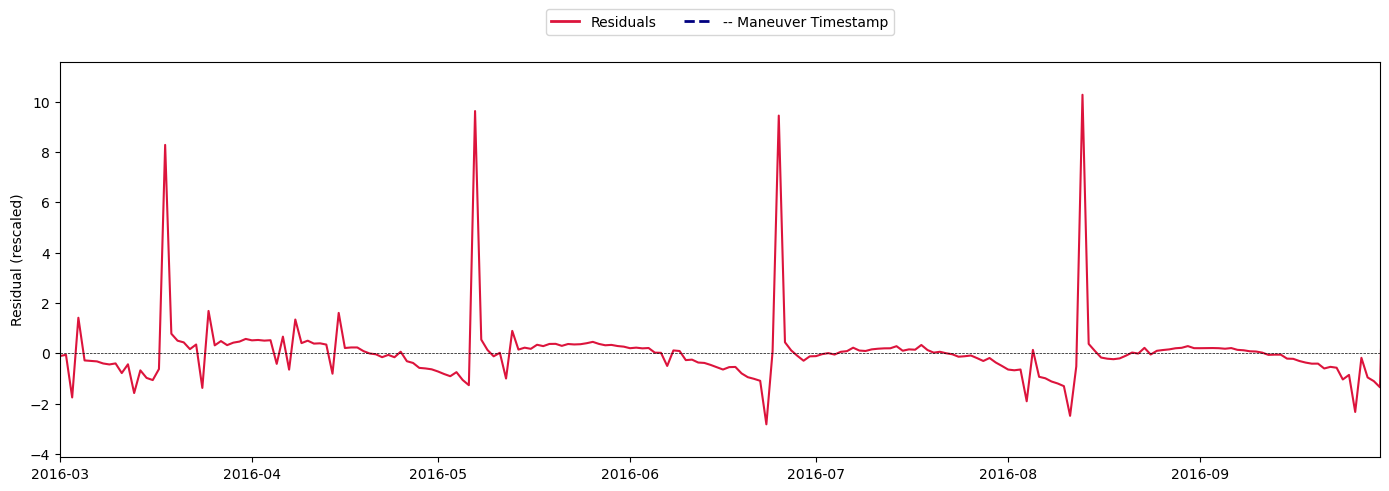

In [931]:
plot_residuals_vs_maneuvers(
    residuals=residuals,
    df_maneuver=df_maneuver,
    xlim= ("2016-03-01", "2016-09-30"),
    save_path = "figures/residualsJason1.png"
)